In [1]:
import Drone
from configurations import defaultConfig 
import numpy as np
from plottingFunctions import open_loop_plots, plot_rrt_lines_flipped
import importlib
import ConvexMotionPlanning
import matplotlib as mpl
import matplotlib.pyplot as plt
import RRTAR
import copy

## Testing occupency grid generation
Significantly increase the number of obstacles to check that they are being registered correctly

(20.0, 60.0)

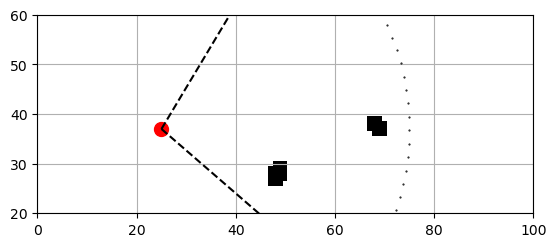

In [2]:
importlib.reload(Drone)

config = defaultConfig()
config.numObstacles = 12
drone = Drone.Drone(config, config)

thrustCommand = 4.3
fpaCommand = 0/180*np.pi
dynRef = drone.coherentCommand(thrustCommand,fpaCommand)
elivatorRef = drone.elevatorFromAlpha(dynRef[1]-dynRef[3])
stateRef = np.hstack(([0,50], dynRef))
action = (thrustCommand, elivatorRef, dynRef)
drone.reset(stateRef)

observation, grid, reward, terminated = drone.step(action)


# random data
fig, ax = plt.subplots()

# define the colors
cmap = mpl.colors.ListedColormap(['w', 'k'])

# create a normalize object the describes the limits of
# each color
bounds = [0., 0.5, 1.]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# plot it
x = drone.ogOrigin[0]
z = drone.ogOrigin[1]
theta = drone.plant.state[3]
beam = drone.lidar_range
angle = drone.lidar_angle
res = drone.lidar_res
ax.plot([x,x+beam*np.cos(theta+angle/2)],[z,z+beam*np.sin(theta+angle/2)],'k--')
ax.plot([x,x+beam*np.cos(theta-angle/2)],[z,z+beam*np.sin(theta-angle/2)],'k--')
a = np.linspace(-angle/2,angle/2,int(res/3))
xs = x+beam*np.cos(theta+a)
zs = z+beam*np.sin(theta+a)
ax.plot(xs,zs,'k.',markersize=1)
ax.scatter(25, 37, color='red', s=100)


ax.imshow(grid, interpolation='none', cmap=cmap, norm=norm)
#ax.set_xlabel("Downrange distance (m)")
#ax.set_ylabel("Vertical distance (m)")
ax.set_xlim(0,100)
ax.grid(True)
plt.gca().invert_yaxis()
ax.set_ylim(20,60)


# RRT Test

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.axes import Axes

def plot_og(ax: Axes, og: np.ndarray, cmap: str = "Greys", vmin=0, vmax=1):
    norm = Normalize(vmin=vmin, vmax=vmax)
    ax.imshow(og.T, cmap=cmap, norm=norm, origin="lower", interpolation=None)


def scatter_plot_2d_vectors(ax, vectors):
    x = [vector[0] for vector in vectors]
    y = [vector[1] for vector in vectors]

    ax.scatter(x, y)
    #fig.xlabel('X')
    #fig.ylabel('Y')
    #fig.title('Scatter Plot of 2D Vectors')
    ax.grid(True)
    #fig.show()

def tree_plot_2d_vectors(vectors, og: np.ndarray, cmap: str = "Greys", vmin=0, vmax=1):
    fig, ax = plt.subplots()

    for vector in vectors:
        x = vector[0]
        y = vector[1]
        index = round(vector[2])

        if index > -1 and index < len(vectors):
            target_vector = vectors[index]
            target_x = target_vector[0]
            target_y = target_vector[1]

            ax.plot([x, target_x], [y, target_y], 'b-')
        ax.scatter(x, y, color='royalblue')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('RRT Tree plot')
    ax.grid(True)

    norm = Normalize(vmin=vmin, vmax=vmax)
    ax.imshow(og.T, cmap=cmap, norm=norm, origin="lower", interpolation=None)
    plt.show()


def solution_plot_2d_vectors(vectors, og: np.ndarray, fig, ax, cmap: str = "Greys", vmin=0, vmax=1):

    for i in range(len(vectors)):
        x = vectors[i][0]
        y = vectors[i][1]+27

        if i > 0:
            target_x = vectors[i-1][0]
            target_y = vectors[i-1][1]+26.5

            ax.plot([x, target_x], [y, target_y], 'b-')
        ax.scatter(x, y, color='royalblue')

    #ax.set_xlabel('Downrange distance (m)')
    ax.set_ylabel("Vertical distance (m)")
    ax.grid(True)

    norm = Normalize(vmin=vmin, vmax=vmax)
    ax.imshow(og.T, cmap=cmap, norm=norm, origin="lower", interpolation=None)
    ax.set_xlim(0,100)
    plt.gca().invert_yaxis()
    ax.set_ylim(20,60)
    ax.grid(True)

    return fig, ax



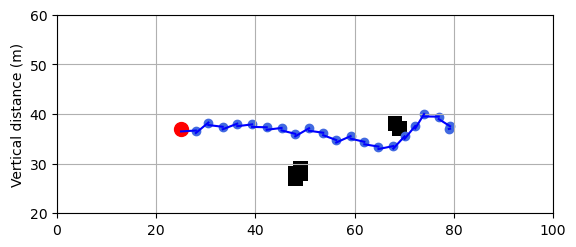

'rrts = RRTStar(grid, n, r_rewire, pbar = False) \nT, gv = rrts.plan(xstart, xgoal)\npath = rrts.route2gv(T, gv)\npath_pts = rrts.vertices_as_ndarray(T, path)\n\nfig = plt.figure()\nax = fig.add_subplot()\n\n#these functions alter ax in-place.\n\nplot_og(ax, grid[midpoint-offset:midpoint+3, 0:80].T)\nplot_start_goal(ax, np.flip(xstart, 0), np.flip(xgoal, 0))\nplot_rrt_lines_flipped(ax, T)\nplot_path(ax, np.flip(path_pts,2))\nTtemp = copy.deepcopy(T)\nax.set_xlabel("Downrange distance in OG (m)")\nax.set_ylabel("Vertical distance in OG (m)")'

In [4]:
midpoint = drone.ogOrigin[1]
offset = 10
lookAhead = 54
orignX = drone.ogOrigin[0]
xstart = np.array([orignX, offset]) 
xgoal = [[orignX+lookAhead, offset], [orignX+lookAhead, offset/4],  [orignX+lookAhead, offset/4*2],  [orignX+lookAhead, offset*6/4]]
n = 10
r_rewire = 5
searchGrid = grid[midpoint-offset:midpoint+offset, 0:85].T.astype(int)
vectorsSave = []

while (len(vectorsSave) < 1):
    vectors = RRTAR.runRRT(xstart[0], xstart[1], 100, 3, 4, searchGrid, xgoal)
    for i in range(1, len(vectors)):
        vectorsSave.append(vectors[i])
#tree_plot_2d_vectors(vectors[0], grid[midpoint-offset:midpoint+offset, 0:85].T.astype(int))
fig, ax = plt.subplots()
for i in range(0, len(vectorsSave)):
    fig, ax = solution_plot_2d_vectors(vectorsSave[i], grid[0:midpoint+offset, 0:85].T.astype(int), fig, ax)
ax.scatter(25, 37, color='red', s=100)
plt.show()
'''rrts = RRTStar(grid, n, r_rewire, pbar = False) 
T, gv = rrts.plan(xstart, xgoal)
path = rrts.route2gv(T, gv)
path_pts = rrts.vertices_as_ndarray(T, path)

fig = plt.figure()
ax = fig.add_subplot()

#these functions alter ax in-place.

plot_og(ax, grid[midpoint-offset:midpoint+3, 0:80].T)
plot_start_goal(ax, np.flip(xstart, 0), np.flip(xgoal, 0))
plot_rrt_lines_flipped(ax, T)
plot_path(ax, np.flip(path_pts,2))
Ttemp = copy.deepcopy(T)
ax.set_xlabel("Downrange distance in OG (m)")
ax.set_ylabel("Vertical distance in OG (m)")'''


## Raytracing Procedure
Demos the raytracing procedure around the above path

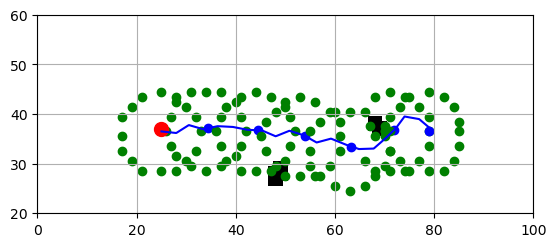

In [5]:
tEnd = 450
path_pts = np.zeros((len(vectorsSave[0]) - 1, 2, 2))
for i in range(len(vectorsSave[0]) - 1):
    path_pts[i] = np.array([[vectorsSave[0][i][1], vectorsSave[0][i][0]],
                          [vectorsSave[0][i+1][1], vectorsSave[0][i+1][0]]])

numDirections = 16
directs = ConvexMotionPlanning.generateDirections(numDirections)

fig, ax = plt.subplots()
#ax.scatter(drone.objects[0,:],drone.objects[1,:], color = "red" )
referencePointsPlot, referenceVelsPlot= ConvexMotionPlanning.calculateReferencePoints(tEnd+1, path_pts)

xRefsToPlot = list(zip(*referencePointsPlot))[0]
yRefsToPlot = list(zip(*referencePointsPlot))[1]

plt.plot(yRefsToPlot, np.array(xRefsToPlot)+26.5, color = 'blue')
indexes = range(len(xRefsToPlot))
indexes = indexes[0::75]
for i in indexes:
    cords = ConvexMotionPlanning.searchFromCord([xRefsToPlot[i], yRefsToPlot[i]], directs, searchGrid.T, limit = 8)
    plt.scatter(cords[:, 1], cords[:, 0]+26.5, color = 'green')
    plt.scatter(yRefsToPlot[i], xRefsToPlot[i]+26.5, color = 'blue')
ax.imshow(grid[0:midpoint+offset, 0:85].T.astype(int).T, cmap=cmap, norm=norm, origin="lower", interpolation=None)
ax.scatter(25, 37, color='red', s=100)
ax.set_xlim(0,100)
ax.set_ylim(20,60)

ax.grid(True)
plt.show()



## Trajectory Refignment

In [6]:

import math
import importlib
importlib.reload(ConvexMotionPlanning)
thrustCommandVal = 4.3
refStates = drone.coherentCommand(thrustCommandVal,0/180*np.pi)
controlRef = (thrustCommandVal, drone.elevatorFromAlpha(refStates[1]-refStates[3]))

iterations = 2000
iter = 0
thrustCommand = np.zeros(iterations)+thrustCommandVal
stateCommand = drone.coherentCommand(thrustCommand[0],0/180*np.pi)
elivCommandRef = drone.elevatorFromAlpha(stateCommand[1]-stateCommand[3])
elivCommand = np.zeros(iterations) + elivCommandRef
xCommand = np.zeros(iterations)
yCommand = np.zeros(iterations)
refCommand = np.zeros((iterations, 4))
timeMulti = 25
Acts, Bcts = drone.calculateCTSABMatrix(refStates, controlRef)
Aopt = np.eye(Acts.shape[0]+2)
#A = Aopt + env.calculateANumerical(stateRefFull, controlRef, env.rhoNom, step=10**-5)*env.dt
Aopt[0, 2] = drone.dt*timeMulti
Aopt[1, 5] = refStates[0]*drone.dt*timeMulti
Aopt[2:,2:] = Aopt[2:,2:]+Acts*drone.dt*timeMulti
Bopt = np.zeros([6,2])
Bopt[2:,0:1] = Bcts*drone.dt*timeMulti
alphaEst = refStates[1] - refStates[3]
Bopt[2, 1] = 1/drone.m*np.cos(alphaEst)*drone.dt*timeMulti
Bopt[5, 1] = 1/drone.m*np.sin(alphaEst)/refStates[0]*drone.dt*timeMulti
xstart = np.concatenate(([0.,0.], np.array(drone.stateEstimate) - np.array(refStates) + np.array([0, 0.01, 0, 0])))
xgoal = np.concatenate(([0.,50 - drone.plant.state[1]], [0.,0.,0.,0.]))

referencePoints, referenceVels = ConvexMotionPlanning.calculateReferencePoints(math.floor(tEnd/timeMulti)+1, path_pts)
referencePointsDyn, referenceVelsDyn = ConvexMotionPlanning.calculateReferencePoints(math.floor(tEnd/timeMulti)+1, path_pts)
print(path_pts[0][0])

for i in range(len(referencePointsDyn)):
    referencePointsDyn[i][0] = referencePointsDyn[i][0]-refStates[0]*np.sin(refStates[3])*i*drone.dt*timeMulti-offset
    referencePointsDyn[i][1] = referencePointsDyn[i][1]-refStates[0]*np.cos(refStates[3])*i*drone.dt*timeMulti-orignX
print(path_pts[0][0])

xsol, usol, cost, infeasbility = ConvexMotionPlanning.localTrajOpt(Aopt, Bopt, math.floor(tEnd/timeMulti), grid[midpoint-offset:, 0:80], referencePoints, referencePointsDyn, xstart, xgoal)

for i in range(np.min((tEnd-timeMulti-1, iterations-iter))):
    iDrop = math.floor(i/timeMulti)
    iNext = iDrop+1
    ifrac1 = (timeMulti - i%timeMulti)/timeMulti
    ifrac2 = (i%timeMulti)/timeMulti
    thrustCommand[iter+i] = ifrac1*usol[iDrop][1] + ifrac2*usol[iNext][1]  + thrustCommandVal 
    elivCommand[iter + i] = ifrac1*usol[iDrop][0] + ifrac2*usol[iNext][0] + elivCommandRef
    xCommand[iter+i] = ifrac1*xsol[iDrop][0] + ifrac2*xsol[iNext][0] +refStates[0]*np.cos(0)*i*drone.dt+drone.plant.state[0]
    yCommand[iter+i] = ifrac1*xsol[iDrop][1] + ifrac2*xsol[iNext][1] + refStates[0]*np.sin(0)*i*drone.dt+drone.plant.state[1]
    refCommand[iter+i, :] = ifrac1*xsol[iDrop][2:6].T + ifrac2*xsol[iNext][2:6].T + np.array(refStates)



[10. 25.]
[10. 25.]
line 113 in 0.0206 seconds
line 194 in 0.0337 seconds


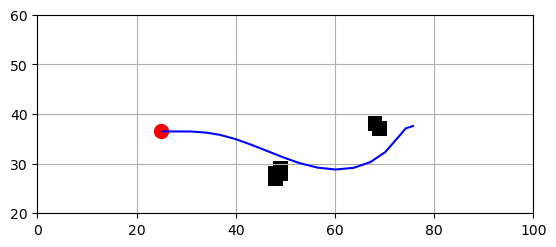

In [7]:
fig, ax = plt.subplots()
ax.imshow(grid[0:midpoint+offset, 0:85].T.astype(int).T, cmap=cmap, norm=norm, origin="lower", interpolation=None)

ax.set_xlim(0,100)
ax.set_ylim(20,60)
ax.scatter(25, 36.5, color='red', s=100)
plt.plot(xCommand[0:tEnd-timeMulti-1]+25, yCommand[0:tEnd-timeMulti-1]-13.5, color = 'blue')


ax.grid(True)
plt.show()


/home/matthew/Documents/Flappy-Junco/plottingFunctions.py:146: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


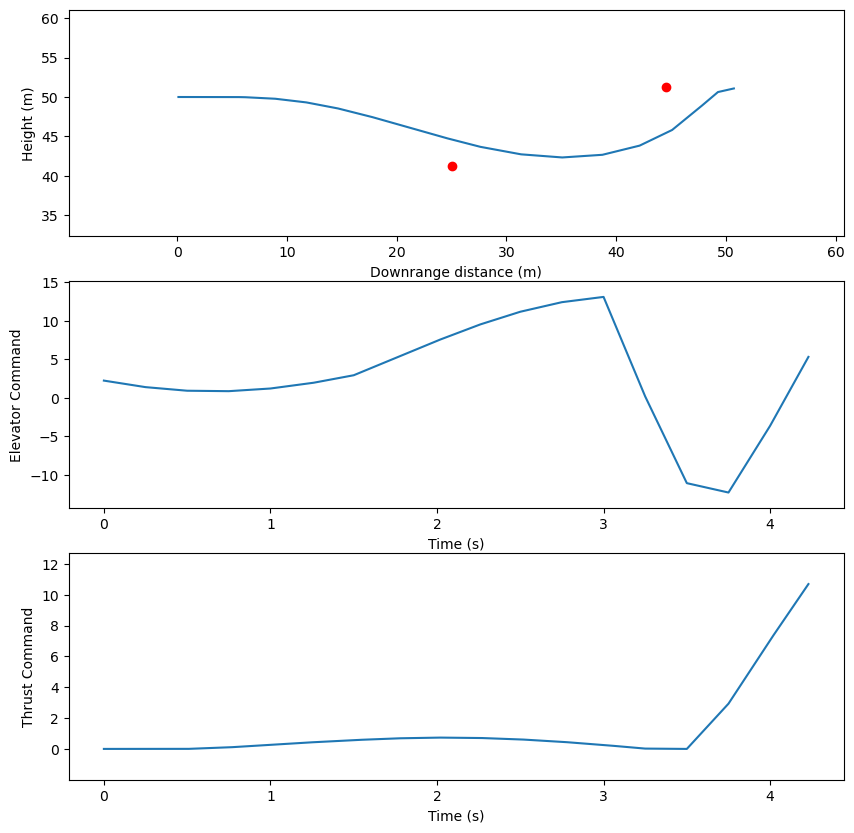

In [8]:
open_loop_plots(0, tEnd-timeMulti-1,xCommand, yCommand,thrustCommand, elivCommand, drone)